In [3]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/


In [4]:
!kaggle datasets download -d muratkokludataset/rice-image-dataset


Dataset URL: https://www.kaggle.com/datasets/muratkokludataset/rice-image-dataset
License(s): CC0-1.0


In [5]:
!unzip rice-image-dataset.zip -d rice_data


Streaming output truncated to the last 5000 lines.
  inflating: rice_data/Rice_Image_Dataset/Karacadag/Karacadag (55).jpg  
  inflating: rice_data/Rice_Image_Dataset/Karacadag/Karacadag (550).jpg  
  inflating: rice_data/Rice_Image_Dataset/Karacadag/Karacadag (5500).jpg  
  inflating: rice_data/Rice_Image_Dataset/Karacadag/Karacadag (5501).jpg  
  inflating: rice_data/Rice_Image_Dataset/Karacadag/Karacadag (5502).jpg  
  inflating: rice_data/Rice_Image_Dataset/Karacadag/Karacadag (5503).jpg  
  inflating: rice_data/Rice_Image_Dataset/Karacadag/Karacadag (5504).jpg  
  inflating: rice_data/Rice_Image_Dataset/Karacadag/Karacadag (5505).jpg  
  inflating: rice_data/Rice_Image_Dataset/Karacadag/Karacadag (5506).jpg  
  inflating: rice_data/Rice_Image_Dataset/Karacadag/Karacadag (5507).jpg  
  inflating: rice_data/Rice_Image_Dataset/Karacadag/Karacadag (5508).jpg  
  inflating: rice_data/Rice_Image_Dataset/Karacadag/Karacadag (5509).jpg  
  inflating: rice_data/Rice_Image_Dataset/Karacadag/

In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import Dense,Dropout,Flatten,Conv2D,MaxPooling2D,BatchNormalization
from tensorflow.keras.models import Sequential
from keras import callbacks
from keras.optimizers import Adam
from sklearn.metrics import confusion_matrix,classification_report
from sklearn.model_selection import train_test_split
import os
import keras
from tabulate import tabulate
import matplotlib.cm as cm
import random
import warnings
warnings.filterwarnings("ignore")

In [7]:
dir_='rice_data/Rice_Image_Dataset'
os.listdir(dir_)

['Karacadag',
 'Basmati',
 'Jasmine',
 'Arborio',
 'Rice_Citation_Request.txt',
 'Ipsala']

In [8]:
classes=os.listdir(dir_) #storing names of classes
#removing text file
classes.remove( 'Rice_Citation_Request.txt')
classes

['Karacadag', 'Basmati', 'Jasmine', 'Arborio', 'Ipsala']

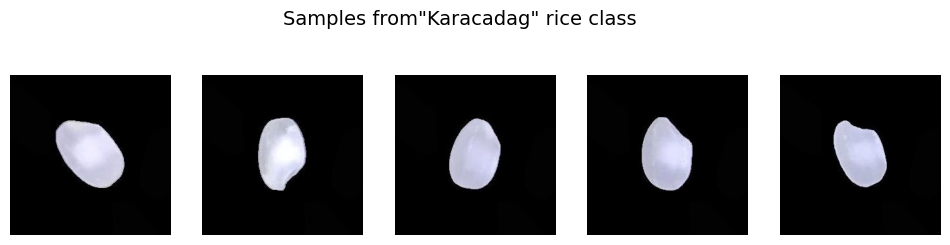

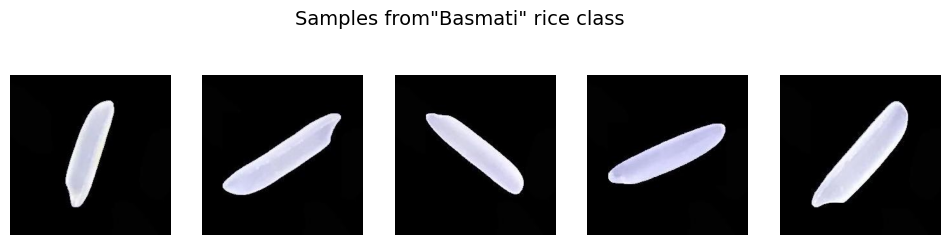

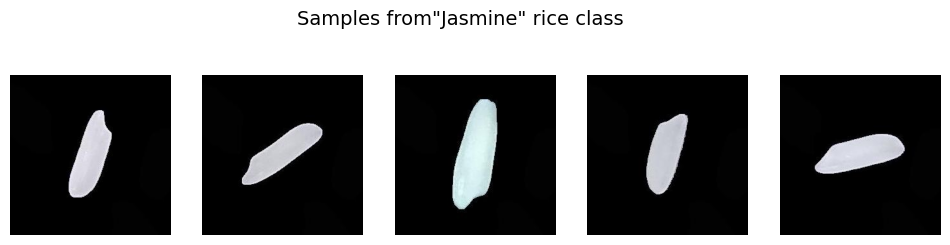

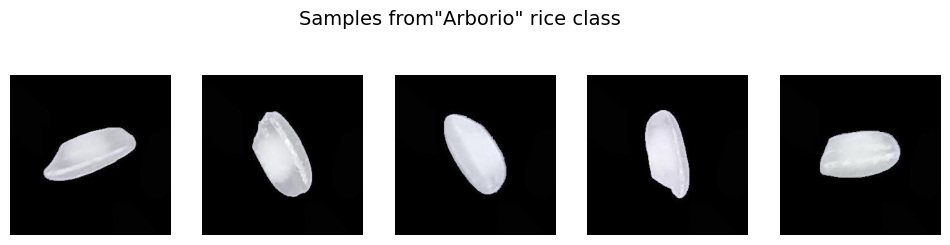

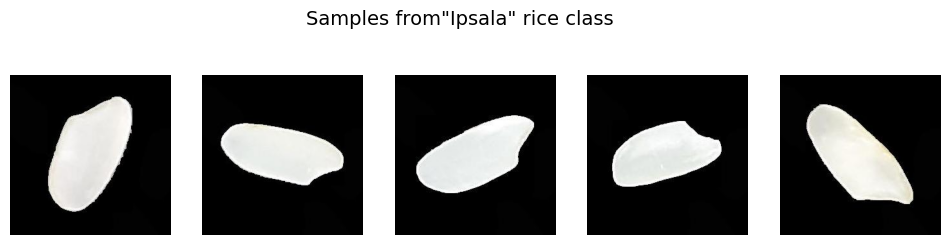

In [9]:
# Plotting random images of each file(class)

for rice_class in classes:
    class_dir=os.path.join(dir_,rice_class) #fetching the class directory path
    image_path=os.listdir(class_dir) #list of images
    random_images=random.sample(image_path,k=5) #selecting 5 sample random images

    #plotting the sample images
    fig,ax=plt.subplots(1,5,figsize=(12,3))
    plt.suptitle(f'Samples from"{rice_class}" rice class',fontsize=14)

    for i,random_image in enumerate(random_images):
        image_path=os.path.join(class_dir,random_image)
        image=tf.keras.utils.load_img(image_path)

        ax[i].imshow(image)#plots image
        ax[i].axis('off')
    plt.subplots_adjust(hspace=-0.2)
    plt.show()
    print("\n")

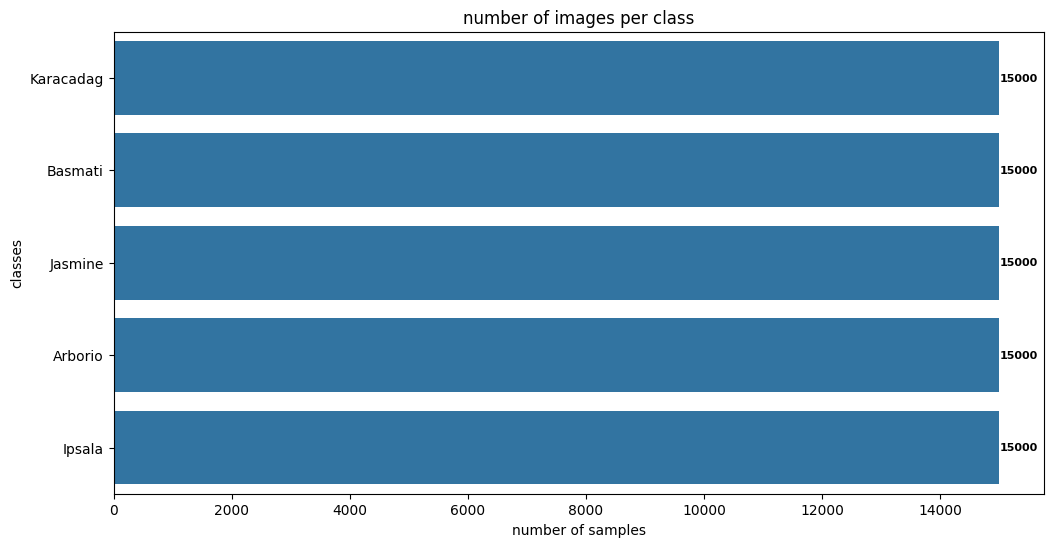

In [10]:
counts=[]
for rice_class in classes:
    class_dir=os.path.join(dir_,rice_class)
    counts.append(len(os.listdir(class_dir)))
plt.figure(figsize=(12,6))
ax=sns.barplot(x=counts,y=classes)

for i,p in enumerate(ax.patches):
    width=p.get_width()
    ax.text(width+5,p.get_y()+p.get_height()/2.,'{}'.format(counts[i]),
            va="center", fontsize=8, color='black', fontweight='bold')
plt.title('number of images per class')
plt.ylabel('classes')
plt.xlabel('number of samples')
plt.show()

In [11]:
# Create a list of tuples that contain image paths and their class labels
image_data=[]

for rice_class in classes:
    class_dir=os.path.join(dir_,rice_class)
    images_path=os.listdir(class_dir)

    for image in images_path:
        image_path=os.path.join(class_dir,image)
        image_data.append((image_path,rice_class))

# converting the list to pandas DataFrame
df=pd.DataFrame(image_data,columns=['image path','Label'])

#shuffling the dataframe for randomness
df=df.sample(frac=1,random_state=42).reset_index(drop=True)

df.head()

,image path,Label
0,rice_data/Rice_Image_Dataset/Basmati/basmati (...,Basmati
1,rice_data/Rice_Image_Dataset/Karacadag/Karacad...,Karacadag
2,rice_data/Rice_Image_Dataset/Basmati/basmati (...,Basmati
3,rice_data/Rice_Image_Dataset/Ipsala/Ipsala (24...,Ipsala
4,rice_data/Rice_Image_Dataset/Ipsala/Ipsala (10...,Ipsala


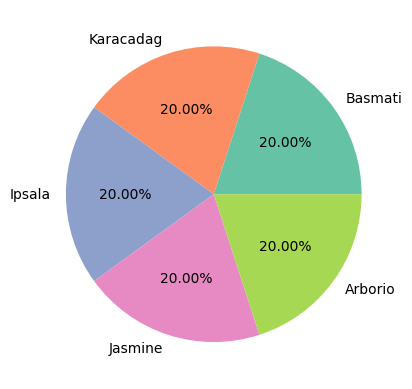

In [12]:
#pie chart to show distribution of labels in dataframe
labels = df['Label'].value_counts().index
count=df['Label'].value_counts().values

plt.pie(count,labels=labels,autopct='%0.2f%%',colors = cm.Set2.colors)
plt.show()

Loading Images and splitting the data

In [13]:
train_df=tf.keras.utils.image_dataset_from_directory(dir_,
                                               validation_split=0.3,
                                               subset="training",
                                               seed=42,
                                               image_size=(224,224),
                                               batch_size=32,
                                               label_mode='categorical')
temp_df=tf.keras.utils.image_dataset_from_directory(dir_,
                                               validation_split=0.3,
                                               subset="validation",
                                               seed=42,
                                               image_size=(224,224),
                                               batch_size=32,
                                               label_mode='categorical')


Found 75000 files belonging to 5 classes.
Using 52500 files for training.
Found 75000 files belonging to 5 classes.
Using 22500 files for validation.


In [14]:
length=int(0.5*len(temp_df))
val_df=temp_df.take(length)
test_df=temp_df.skip(length)


In [15]:
#Normalizing the data
train_df=train_df.map(lambda x,y: (x/255,y)) #x refers to images,y refers to labels
test_df=test_df.map(lambda x,y: (x/255,y))
val_df=val_df.map(lambda x,y: (x/255,y))

Model Building

In [16]:
checkpoint=keras.callbacks.ModelCheckpoint( #This saves your model to disk after each epoch, so you can recover it later or load the best version if something goes wrong.
    filepath='model_checkpoint_epoch_{epoch:02d}.keras',#Saves models with file names
    verbose=1 #Prints out a message each time a checkpoint is saved.

)
reduce_lr=keras.callbacks.ReduceLROnPlateau( #This automatically reduces the learning rate if the validation loss plateaus (i.e., doesn’t improve)
    monitor='val_loss',
    factor=0.5,#Cut the learning rate in half if no improvement.
    patience=10,#Wait for 10 epochs before reducing it.
    verbose=1,#Print when it reduces LR.
    min_delta=0.001,#Only count as an improvement if the loss decreases by at least 0.001
    min_lr=1e-5  #The learning rate won't go below this value.
)
early_stopping=keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,#Requires at least this much improvement to count as progress.
    patience=5,#If no improvement for 5 consecutive epochs, stop training.
    verbose=1,
    start_from_epoch=10 #Don’t apply early stopping before epoch 10
)

In [17]:
model=Sequential()
model.add(Conv2D(32,(3,3),activation='relu',input_shape=(224,224,3))) # 32 refers to number of kernels/filters,(3,3)->filter size
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128,(3,3),activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D())

model.add(Flatten())
model.add(Dense(128,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(256,activation='relu'))
model.add(Dense(5,activation='softmax'))

opt=Adam(learning_rate=0.0001)
model.compile(loss='categorical_crossentropy',optimizer=opt,metrics=['accuracy'])
model.summary()

history=model.fit(train_df,epochs=30,validation_data=val_df,callbacks=[checkpoint,reduce_lr,early_stopping])


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 222, 222, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 109, 109, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 107, 107, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 107, 107, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 53, 53, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 51, 51, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 51, 51, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 49, 49, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 49, 49, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 73728)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     9,437,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │         1,285 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,751,045 (37.20 MB)

 Trainable params: 9,750,213 (37.19 MB)

 Non-trainable params: 832 (3.25 KB)

Epoch 1/30
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step - accuracy: 0.9389 - loss: 0.1837
Epoch 1: saving model to model_checkpoint_epoch_01.keras
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 169s 94ms/step - accuracy: 0.9389 - loss: 0.1837 - val_accuracy: 0.8987 - val_loss: 0.4744 - learning_rate: 1.0000e-04
Epoch 2/30
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9869 - loss: 0.0464
Epoch 2: saving model to model_checkpoint_epoch_02.keras
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 147s 90ms/step - accuracy: 0.9869 - loss: 0.0464 - val_accuracy: 0.9892 - val_loss: 0.0393 - learning_rate: 1.0000e-04
Epoch 3/30
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9900 - loss: 0.0373
Epoch 3: saving model to model_checkpoint_epoch_03.keras
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 147s 89ms/step - accuracy: 0.9900 - loss: 0.0373 - val_accuracy: 0.9943 - val_loss: 0.0218 - learning_rate: 1.0000e-04
Epoch 4/30
1641/1641 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - accuracy: 0.9899 - loss: 0.0375
Epoch 4: saving model t

Evaluation

In [20]:
history_df = pd.DataFrame(history.history)
print(tabulate(history_df,headers='keys',tablefmt='psql'))

+----+------------+------------+----------------+-------------+-----------------+
|    |   accuracy |       loss |   val_accuracy |    val_loss |   learning_rate |
|----+------------+------------+----------------+-------------+-----------------|
|  0 |   0.972038 | 0.092982   |       0.898704 |  0.474417   |          0.0001 |
|  1 |   0.986495 | 0.0478377  |       0.989169 |  0.0393337  |          0.0001 |
|  2 |   0.989905 | 0.0366005  |       0.994318 |  0.0217978  |          0.0001 |
|  3 |   0.990952 | 0.0332838  |       0.995117 |  0.0233856  |          0.0001 |
|  4 |   0.993162 | 0.0281839  |       0.996626 |  0.0150666  |          0.0001 |
|  5 |   0.994343 | 0.0216748  |       0.601562 | 16.1583     |          0.0001 |
|  6 |   0.994514 | 0.0224826  |       0.993874 |  0.0256268  |          0.0001 |
|  7 |   0.9952   | 0.0189735  |       0.956765 |  0.172727   |          0.0001 |
|  8 |   0.994438 | 0.0248439  |       0.998491 |  0.00747766 |          0.0001 |
|  9 |   0.99706

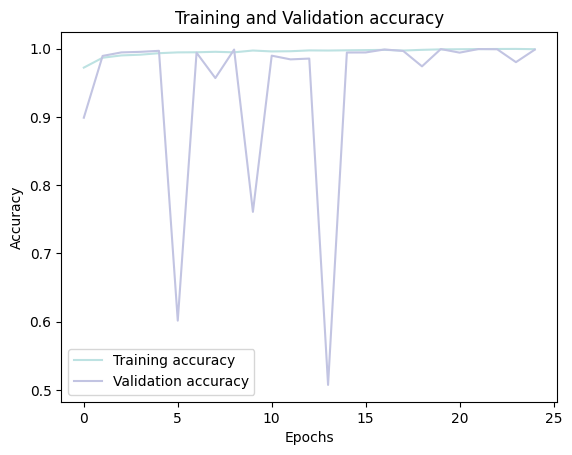

In [21]:
history_df = pd.DataFrame(history.history)

plt.plot(history_df.loc[:, ['accuracy']], "#BDE2E2", label='Training accuracy')
plt.plot(history_df.loc[:, ['val_accuracy']], "#C2C4E2", label='Validation accuracy')

plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

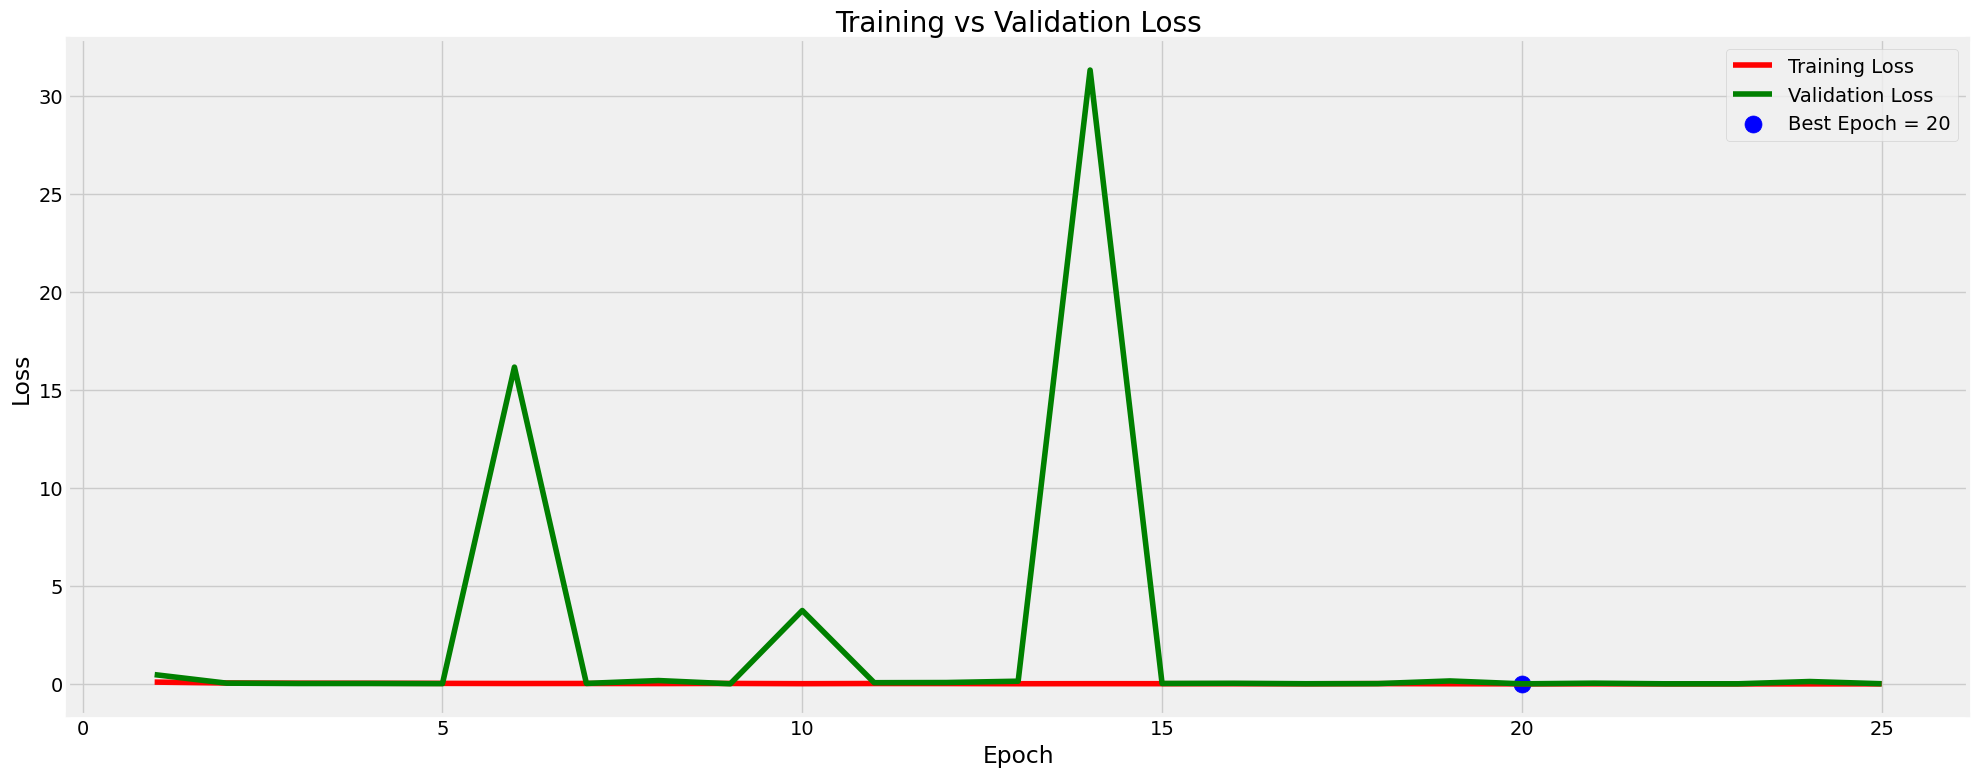


Best model found at epoch 20
Loading model: model_checkpoint_epoch_19.keras
352/352 ━━━━━━━━━━━━━━━━━━━━ 20s 35ms/step - accuracy: 0.9756 - loss: 0.1371

Test Performance:
Loss     : 0.15080
Accuracy : 97.51%


In [22]:
# Extract training and validation loss from history
train_loss = history.history['loss']
val_loss = history.history['val_loss']

# Find the epoch with the lowest validation loss
best_epoch = np.argmin(val_loss)
best_val_loss = val_loss[best_epoch]

# Prepare x-axis (epochs) for the plot
epochs = [i + 1 for i in range(len(train_loss))]
highlight_label = f'Best Epoch = {best_epoch + 1}'

# Plot the loss curves
plt.figure(figsize=(20, 8))
plt.style.use('fivethirtyeight')

plt.plot(epochs, train_loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'g', label='Validation Loss')
plt.scatter(best_epoch + 1, best_val_loss, s=150, c='blue', label=highlight_label)

plt.title('Training vs Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

# Build the filename of the best model
model_filename = f'model_checkpoint_epoch_{best_epoch:02d}.keras'

print(f"\nBest model found at epoch {best_epoch + 1}")
print(f"Loading model: {model_filename}")

# Load and evaluate the best model
best_model = keras.models.load_model(model_filename)
test_loss, test_accuracy = best_model.evaluate(test_df)

print("\nTest Performance:")
print(f"Loss     : {test_loss:.5f}")
print(f"Accuracy : {test_accuracy * 100:.2f}%")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 614ms/step


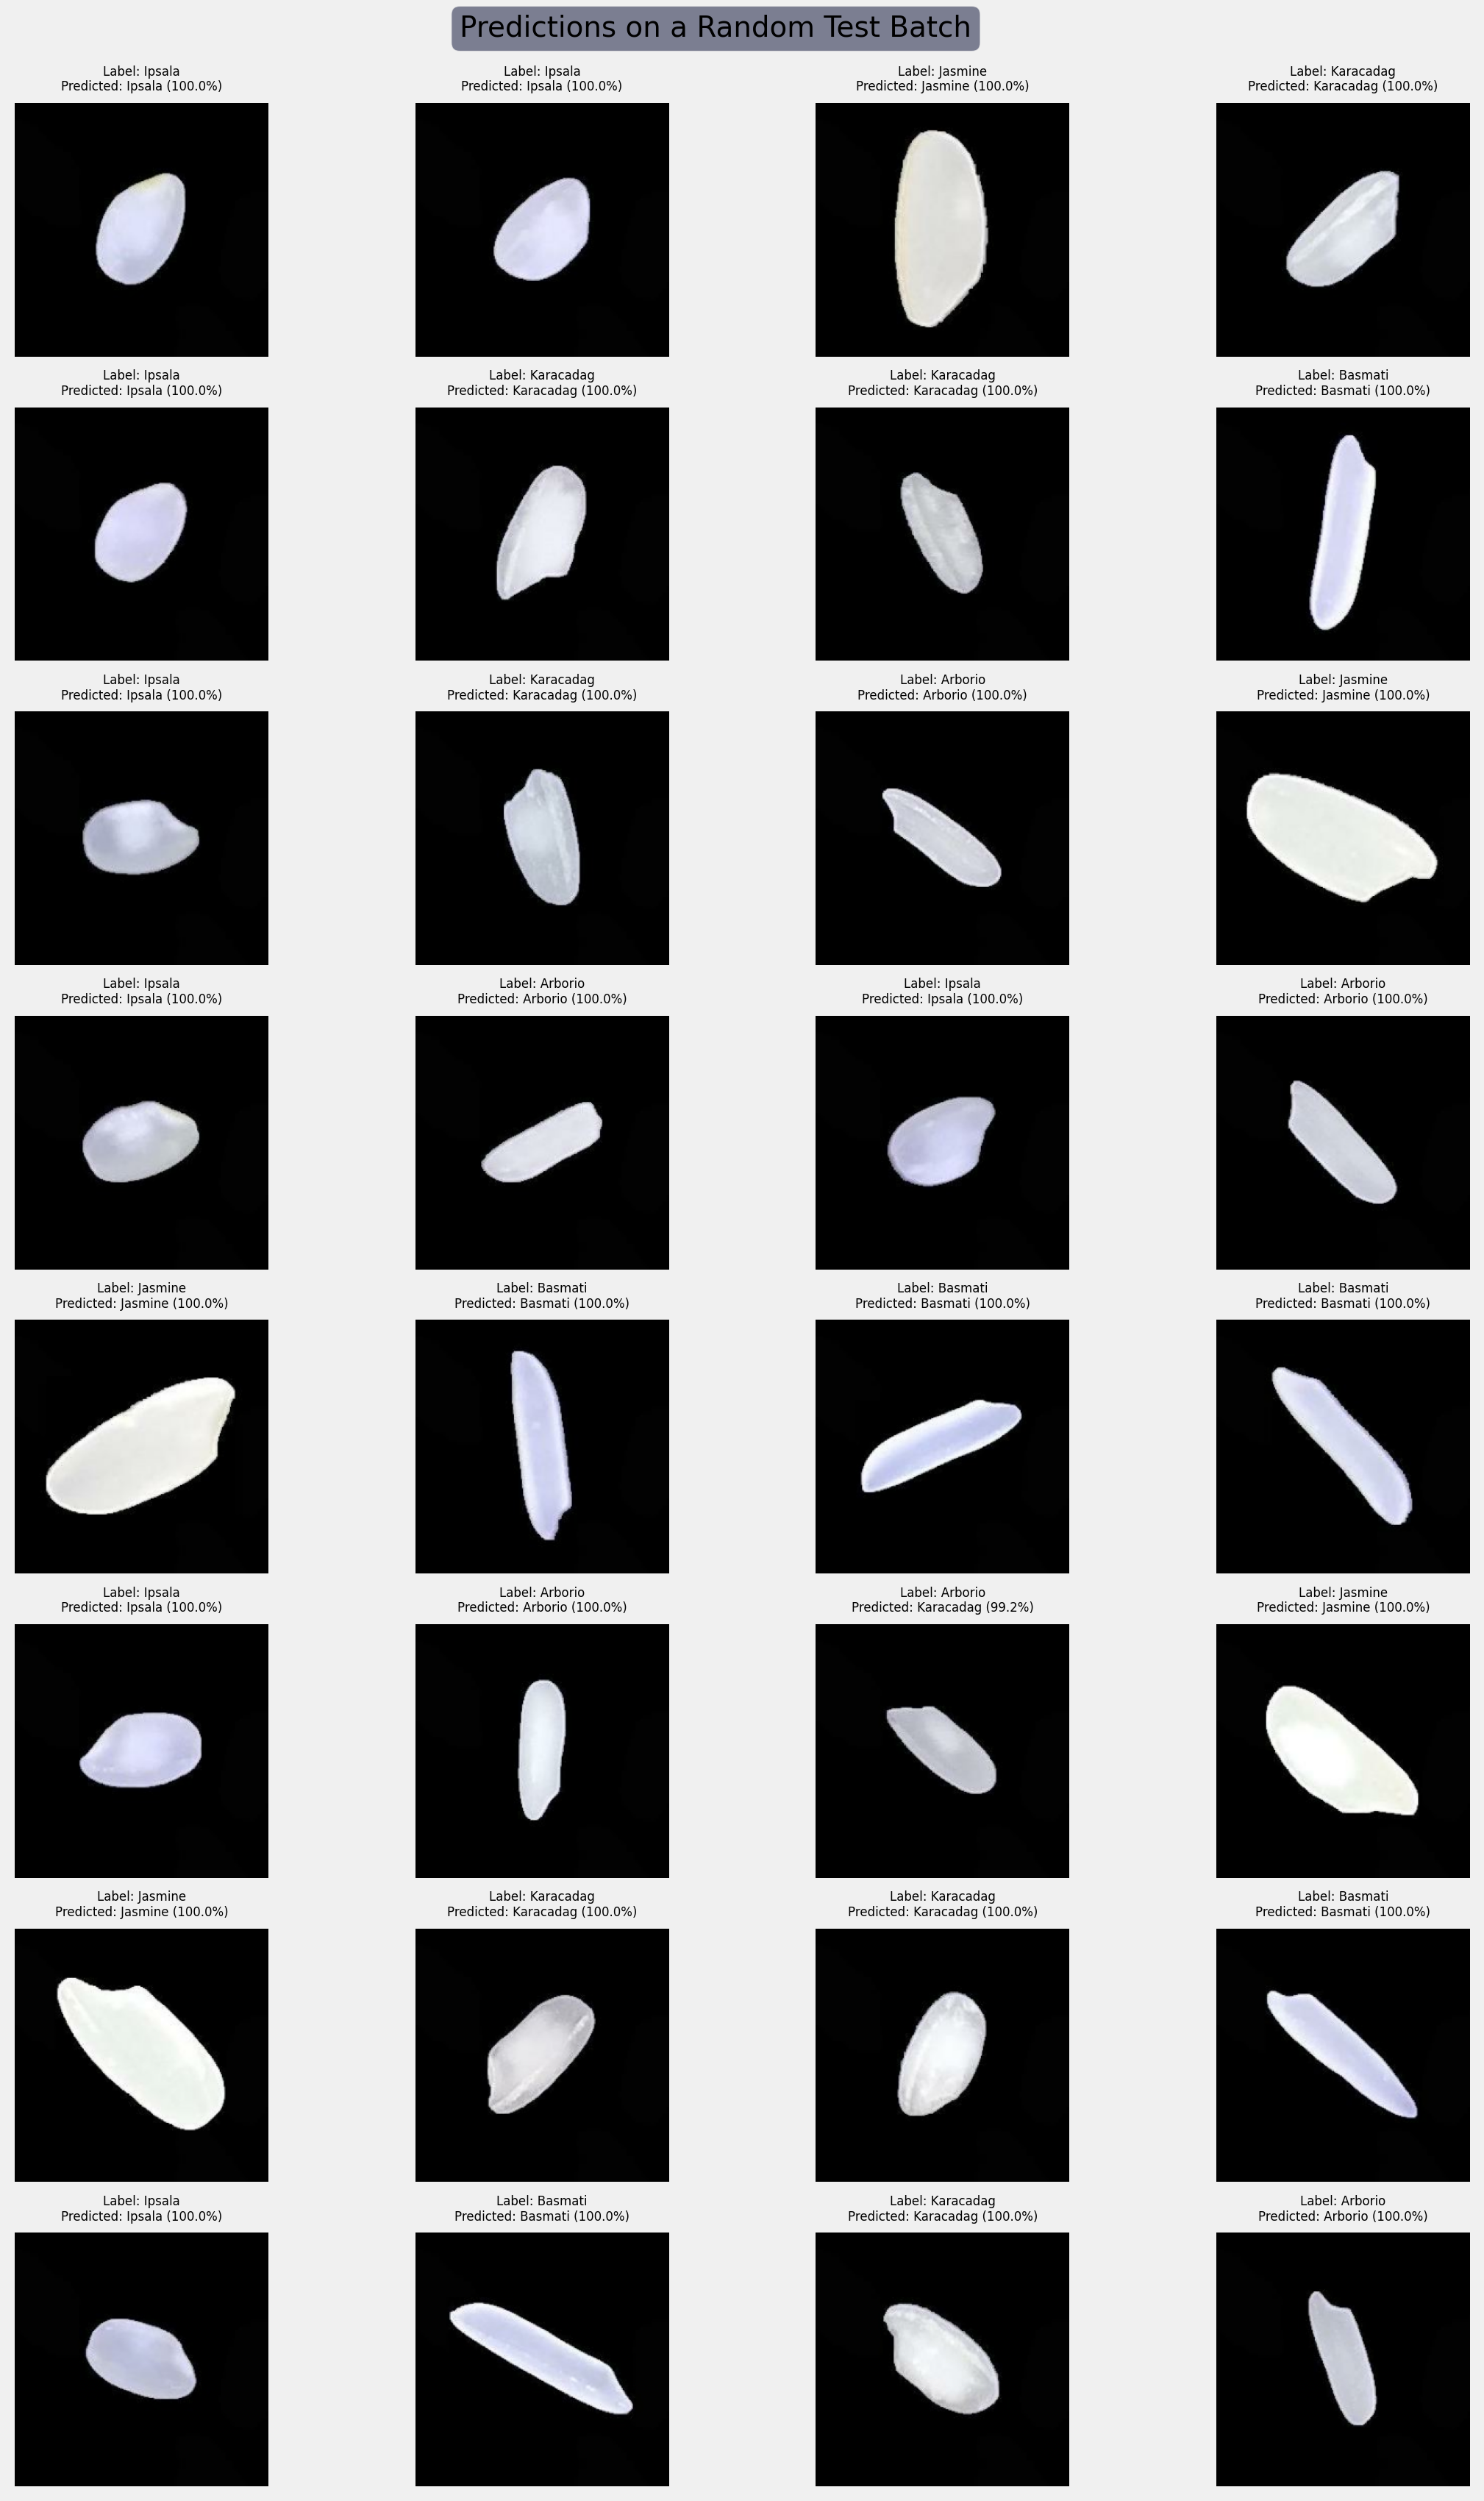

In [23]:
# Prepare test data for visualization (rescale back to [0, 255])
visual_test = test_df.map(lambda x, y: (x * 255, y))

# Get one batch from the test dataset
test_batch = next(visual_test.as_numpy_iterator())
images, labels_onehot = test_batch

# Normalize images back to [0, 1] for prediction
images_for_pred = images / 255.0

# Predict using the best model
pred_probs = best_model.predict(images_for_pred)
pred_classes = np.argmax(pred_probs, axis=1)
true_classes = np.argmax(labels_onehot, axis=1)

# Plot images with predictions
fig, axes = plt.subplots(8, 4, figsize=(12, 20), dpi=200)
axes = axes.flatten()

plt.suptitle('Predictions on a Random Test Batch',
             fontsize=14,
             bbox=dict(facecolor='#4a4e69', alpha=0.7, boxstyle='round,pad=0.3'),
             y=0.91)

for i, ax in enumerate(axes):
    ax.imshow(images[i].astype(int))
    ax.axis('off')
    ax.set_title(
        f"Label: {classes[true_classes[i]]}\n"
        f"Predicted: {classes[pred_classes[i]]} ({100 * np.max(pred_probs[i]):.1f}%)",
        fontsize=6
    )

plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 605ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 108ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━

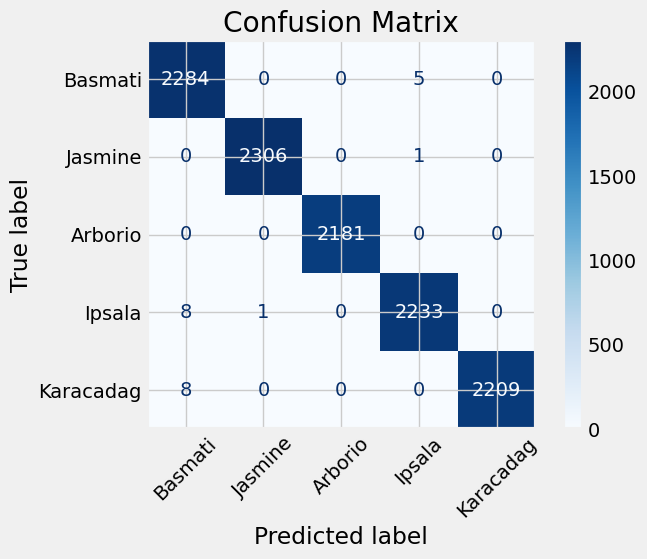

In [24]:
import numpy as np
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# Initialize lists to store true and predicted labels
y_true = []
y_pred = []

# Loop through batches in the test dataset
for images, labels in test_df:
    preds = model.predict(images)

    # Convert from one-hot encoded labels to class indices
    y_true.extend(np.argmax(labels.numpy(), axis=1))
    y_pred.extend(np.argmax(preds, axis=1))


class_names = ['Basmati', 'Jasmine', 'Arborio', 'Ipsala', 'Karacadag']

# Print classification report
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=class_names))

# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap=plt.cm.Blues, xticks_rotation=45)
plt.title("Confusion Matrix")
plt.show()
